## Finding best MA

[*********************100%%**********************]  1 of 1 completed


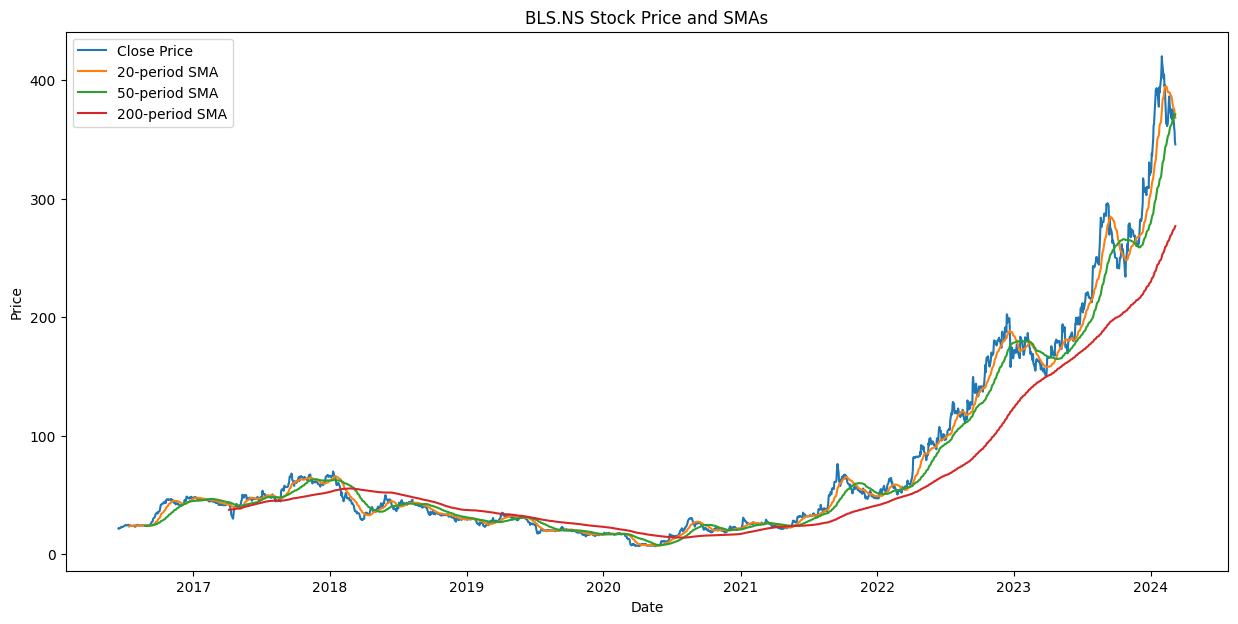

Best SMA Length: 33
Train Return: 0.0301
Test Return: 0.0488
p-value: 0.0177


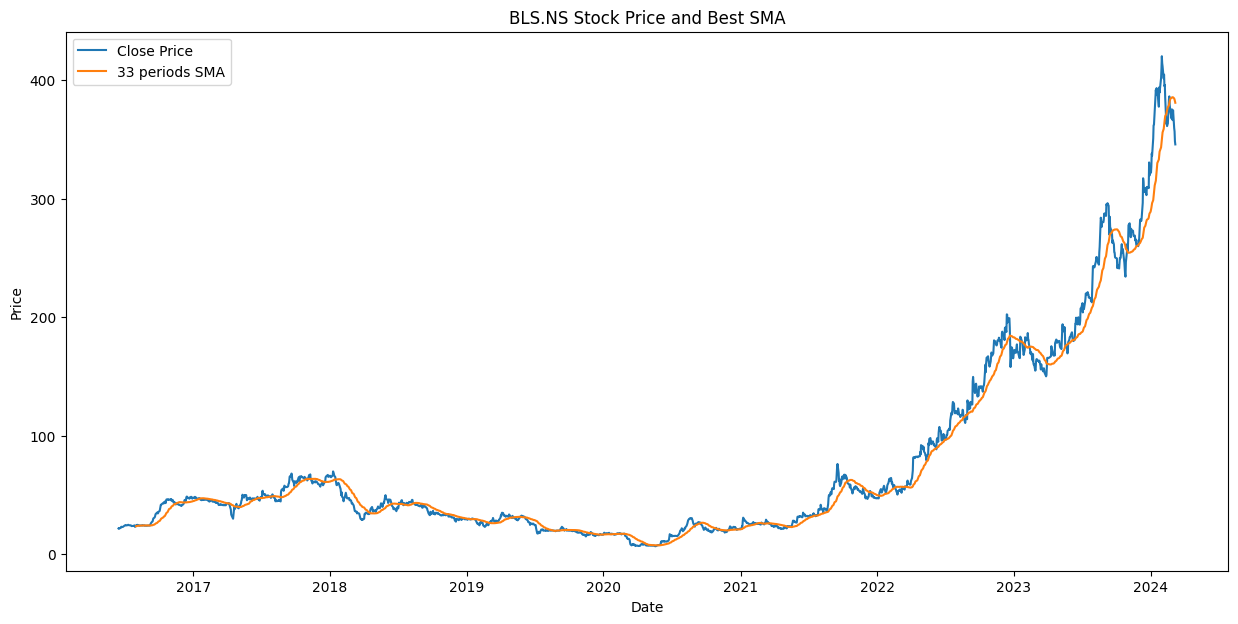

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from scipy.stats import ttest_ind

# Define stock symbol and historical data range
symbol = "BLS.NS"
num_of_years = 10
start_date = dt.datetime.now() - dt.timedelta(days=365.25 * num_of_years)
end_date = dt.datetime.now()

# Fetch stock data using yfinance
data = yf.download(symbol, start=start_date, end=end_date)

# Calculate Simple Moving Averages (SMAs) for different periods
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

# Plotting stock price and its SMAs
plt.figure(figsize=[15, 7])
plt.plot(data['Close'], label='Close Price')
plt.plot(data['SMA_20'], label='20-period SMA')
plt.plot(data['SMA_50'], label='50-period SMA')
plt.plot(data['SMA_200'], label='200-period SMA')
plt.title(f'{symbol} Stock Price and SMAs')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Analysis to find the best SMA for predicting future returns
days_forward = 10
results = []

# Testing different SMA lengths
for sma_length in range(20, 500):
    data['SMA'] = data['Close'].rolling(sma_length).mean()
    data['Position'] = data['Close'] > data['SMA']
    data['Forward Close'] = data['Close'].shift(-days_forward)
    data['Forward Return'] = (data['Forward Close'] - data['Close']) / data['Close']
    
    # Splitting into training and test datasets
    train_data = data[:int(0.6 * len(data))]
    test_data = data[int(0.6 * len(data)):]
    
    # Calculating average forward returns
    train_return = train_data[train_data['Position']]['Forward Return'].mean()
    test_return = test_data[test_data['Position']]['Forward Return'].mean()
    
    # Statistical test
    p_value = ttest_ind(train_data[train_data['Position']]['Forward Return'],
                        test_data[test_data['Position']]['Forward Return'],
                        equal_var=False)[1]
    
    results.append({'SMA Length': sma_length, 
                    'Train Return': train_return, 
                    'Test Return': test_return, 
                    'p-value': p_value})

# Sorting results and printing the best SMA
best_result = sorted(results, key=lambda x: x['Train Return'], reverse=True)[0]
print(f"Best SMA Length: {best_result['SMA Length']}")
print(f"Train Return: {best_result['Train Return']:.4f}")
print(f"Test Return: {best_result['Test Return']:.4f}")
print(f"p-value: {best_result['p-value']:.4f}")

# Plotting the best SMA
data['Best SMA'] = data['Close'].rolling(best_result['SMA Length']).mean()
plt.figure(figsize=[15, 7])
plt.plot(data['Close'], label='Close Price')
plt.plot(data['Best SMA'], label=f"{best_result['SMA Length']} periods SMA")
plt.title(f'{symbol} Stock Price and Best SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()